# Preprocessing features

Preprocessing features based on the training data calculated in [property_calculations](property calculations.ipynb). Missing values will be imputed and scaled. Polynomial features will also be added as a straightforward way to add possible interactions between separate properties to the model training set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import pickle

# Load property_array from property_calculations FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project')

dataset_path = path.join(BASE_DATA_PATH,
                         'property_calculations',
                         'dataset.pkl')

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
function_keys_path = path.join(BASE_DATA_PATH,
                               'property_calculations',
                               'function_keys.pkl')

with open(function_keys_path, 'rb') as g:
    function_keys = pickle.load(g)

In [2]:
train_features = dataset['train features']
train_labels = dataset['train labels']

### Impute missing values, scale, and add 2nd order polynomial features

In [3]:
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(Imputer(strategy='mean'), 
                     StandardScaler(), 
                     PolynomialFeatures(2, include_bias=False))

In [4]:
new_features = pipe.fit_transform(train_features)
print(new_features.shape)

(1519, 12879)


In [5]:
poly = pipe.steps[2][1]
poly_names = np.array(poly.get_feature_names(function_keys[1:]))

### Find a reasonable threshold for univariate feature selection

/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  150   309   467   624   780   935  1089  1242  1394  1545  1695  1844
  1992  2139  2285  2430  2574  2717  2859  3000  3140  3279  3417  3554
  3690  3825  3959  4092  4224  4355  4485  4614  4742  4869  4995  5120
  5244  5367  5489  5610  5730  5849  5967  6084  6200  6315  6429  6542
  6654  6765  6875  6984  7092  7199  7305  7410  7514  7617  7719  7820
  7920  8019  8117  8214  8310  8405  8499  8592  8684  8775  8865  8954
  9042  9129  9215  9300  9384  9467  9549  9630  9710  9789  9867  9944
 10020 10095 10169 10242 10314 10385 10455 10524 10592 10659 10725 10790
 10854 10917 10979 11040 11100 11159 11217 11274 11330 11385 11439 11492
 11544 11595 11645 11694 11742 11789 11835 11880 11924 11967 12009 12050
 12090 12129 12167 12204 12240 12275 12309 12342 12374 12405 12435 12464
 12492 12519 12545 12570 12594 12617 12639 12660 12680 

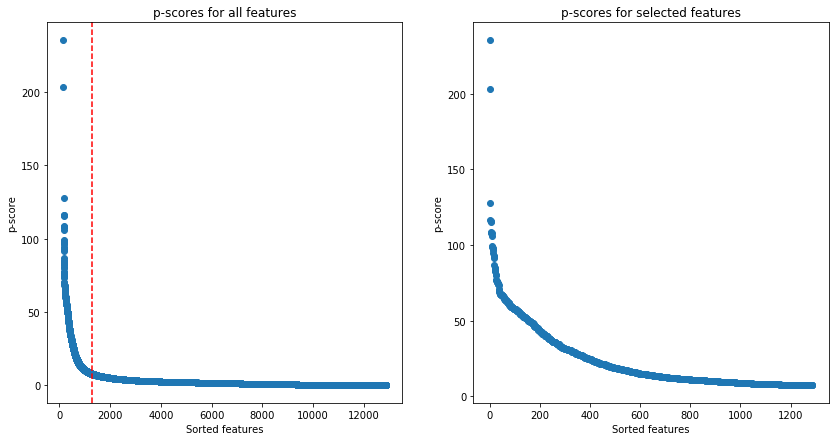

In [6]:
from sklearn.feature_selection import SelectPercentile, f_classif

# Actual selection happens here 
percentile = 10
selector = SelectPercentile(f_classif, percentile=percentile)
selector.fit(new_features, train_labels)
scores = selector.scores_
sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]

# Left plot with all scores
x = range(len(scores))
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121, title='p-scores for all features')
ax1.scatter(x, sorted_scores)
ax1.axvline(x=len(sorted_scores)*percentile/100, color='r', linestyle='--')
ax1.set_xlabel('Sorted features')
ax1.set_ylabel('p-score')

# Right plot with selected scores
sel_mask = selector.get_support()
sel_masked_scores = scores[sel_mask]
sel_masked_scores = sorted(sel_masked_scores, reverse=True)
x = range(len(sel_masked_scores))
ax2 = fig.add_subplot(122, title='p-scores for selected features')
ax2.scatter(x, sel_masked_scores)
ax2.set_xlabel('Sorted features')
ax2.set_ylabel('p-score')
plt.show()

Selection threshold of 10% seems reasonable.
Also, looking the top 20 features selected indicates that they are polynomial and highly dependent on the number of [piperazine](https://en.wikipedia.org/wiki/Piperazine) rings in combination with others. This argues that polynomial features will be useful in training the model. 

In [7]:
sorted_keys = poly_names[sorted_idxs]
for key in sorted_keys[:20]:
    print(key)

fr_Ar_N fr_piperzine
fr_benzene fr_piperzine
fr_aryl_methyl fr_piperzine
SMR_VSA10 fr_piperzine
fr_Imine fr_piperzine
Chi4n fr_piperzine
NumAliphaticHeterocycles fr_piperzine
SMR_VSA2 fr_piperzine
fr_nitrile fr_piperzine
NumAliphaticCarbocycles fr_piperzine
SMR_VSA3 fr_piperzine
SMR_VSA4 fr_piperzine
fr_imide fr_piperzine
fr_C_S fr_piperzine
Chi3v fr_piperzine
SMR_VSA5 fr_piperzine
fr_methoxy fr_piperzine
HallKierAlpha fr_piperzine
fr_bicyclic fr_piperzine
NOCount fr_piperzine
